<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/radon_dataset/keras_tuner_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q keras-tuner
%pip show keras-tuner scikit-learn

Name: keras-tuner
Version: 1.0.1
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: colorama, tqdm, terminaltables, tabulate, numpy, future, scikit-learn, scipy, requests
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, numpy, joblib
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, keras-tuner, imbalanced-learn, fancyimpute


In [ ]:
import datetime, IPython, os, pprint

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer

from kerastuner import HyperModel, Hyperband, Objective
import tensorflow_datasets as tfds
from tensorflow.keras.experimental import LinearModel, WideDeepModel
from tensorflow.keras import Sequential, Input, layers, optimizers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

## データセット読み込み
- radonデータセット[https://www.tensorflow.org/datasets/catalog/radon](https://www.tensorflow.org/datasets/catalog/radon)

# データ読み込み

In [ ]:
def fetch_tf_dataset(data_name, 
                     split='train',
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  dataset, data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return dataset, data_info
  


data_name = 'radon' # @param{type:'string'}
x_name = 'features' # @param{type:'string'}
y_name = 'activity' # @param{type:'string'}
# インメモリでデータを読み込む
batch_size = -1

# データのフェッチ
tf_dataset, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)

tfds.core.DatasetInfo(
    name='radon',
    version=1.0.0,
    description='Radon is a radioactive gas that enters homes through contact
points with the ground. It is a carcinogen that is the primary cause of lung
cancer in non-smokers. Radon levels vary greatly from household to household.
This dataset contains measured radon levels in U.S homes by county and state.
The 'activity' label is the measured radon concentration in pCi/L. Important
predictors are 'floor' (the floor of the house in which the measurement was
taken), 'county' (the U.S. county in which the house is located), and 'Uppm' (a
measurement of uranium level of the soil by county).',
    homepage='http://www.stat.columbia.edu/~gelman/arm/examples/radon/',
    features=FeaturesDict({
        'activity': tf.float32,
        'features': FeaturesDict({
            'Uppm': tf.float32,
            'adjwt': tf.float32,
            'basement': tf.string,
            'cntyfips': tf.int32,
            'county': tf.string,
      

### Dataframeに変換

In [ ]:
%%time

def convert_tfds_to_df(tf_ds, x_key, y_key):
  '''tf DatasetをDataframeに変換'''
  
  # yについて{key:numpy}形式のdictに変換
  y = {}
  y[y_key] = tf_ds[y_key].numpy()

  # xについて[{key:numpy},{key:numpy},,,]形式のdictに変換
  x = {}
  for f_key, element in tf_ds[x_key].items():
    if element.dtype == 'string':
      x[f_key] = _convert_byte_np_to_string_np(bytes_np=element.numpy())
    else:
      x[f_key] = element.numpy()
  
  y_df = pd.DataFrame.from_dict(y)
  x_df = pd.DataFrame.from_dict(x)
  df = pd.concat([y_df, x_df], axis=1)

  return df


def _convert_byte_np_to_string_np(bytes_np, decode_char='utf-8'):
  '''バイナリ文字列形式のnumpy配列を文字列形式のnumpy配列に変換'''
  decode_np = np.array([])
  for b in bytes_np:
    decode_np = np.append(decode_np, b.decode(decode_char))
  decode_np = decode_np.astype('object')
  return decode_np


# tf datasetからDataframeに変換
dataset = convert_tfds_to_df(tf_dataset, x_key=x_name, y_key=y_name)


display(dataset.head())
display(dataset.shape)


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,activity,Uppm,adjwt,basement,cntyfips,county,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,state,state2,stfips,stopdt,stoptm,stratum,typebldg,wave,windoor,zip,zipflag
0,1.6,2.49759,292.219543,N,3,ALLEN,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,IN,IN,18,11689,2235,2,1,92,,46835,0
1,0.5,2.66527,364.958313,N,25,YAVAPAI,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,AZ,AZ,4,22888,1010,2,1,56,,86325,0
2,3.0,2.43343,626.564575,Y,17,MIDDLESEX,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,MA,MA,25,32488,1000,1,1,23,,1778,0
3,0.6,2.43343,570.611755,N,17,MIDDLESEX,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,MA,MA,25,32688,1200,1,1,62,,1432,0
4,1.2,2.10811,426.798859,Y,95,JACKSON,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,MO,MO,29,32488,610,2,1,91,,64134,0


(12573, 28)

'y_col:activity'

"x_cols num:27, names:Index(['Uppm', 'adjwt', 'basement', 'cntyfips', 'county', 'dupflag', 'floor',\n       'idnum', 'lat', 'lon', 'pcterr', 'region', 'rep', 'room', 'startdt',\n       'starttm', 'state', 'state2', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'windoor', 'zip', 'zipflag'],\n      dtype='object')"

CPU times: user 4.91 s, sys: 254 ms, total: 5.16 s
Wall time: 5.17 s


## 文字列をone-hotエンコード

In [ ]:
%%time

def one_hot_encode_df_val(df, target_col):
  '''文字列のカラムをone-hot-encodeしたカラムに置き換え
  INFO :　新規のカラムは先頭に挿入していく
  WARNING : target_colはdropされる
  '''
  mlb = MultiLabelBinarizer()
  one_hot_feature = mlb.fit_transform([{str(val)} for val in df[target_col].values])
  insert_columns = [target_col+'_'+str(x+1) for x in range(len(one_hot_feature[0]))]
  insert_df = pd.DataFrame(one_hot_feature, columns=insert_columns)
  df = df.drop(columns=target_col)
  df = pd.concat([insert_df, df], axis=1)
  return df

encode_cols = ['basement', 'county', 'state', 'state2', 'windoor']
for col in encode_cols:
  dataset = one_hot_encode_df_val(dataset, col)
display(dataset.head())


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,windoor_1,state2_1,state2_2,state2_3,state2_4,state2_5,state2_6,state2_7,state2_8,state2_9,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11,county_12,county_13,county_14,county_15,county_16,county_17,county_18,county_19,county_20,county_21,county_22,...,county_374,county_375,county_376,county_377,county_378,county_379,county_380,county_381,county_382,county_383,county_384,county_385,county_386,basement_1,basement_2,basement_3,basement_4,activity,Uppm,adjwt,cntyfips,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,stfips,stopdt,stoptm,stratum,typebldg,wave,zip,zipflag
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.6,2.49759,292.219543,3,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,18,11689,2235,2,1,92,46835,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.5,2.66527,364.958313,25,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,4,22888,1010,2,1,56,86325,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,2.43343,626.564575,17,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,25,32488,1000,1,1,23,1778,0
3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.6,2.43343,570.611755,17,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,25,32688,1200,1,1,62,1432,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.2,2.10811,426.798859,95,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,29,32488,610,2,1,91,64134,0


'y_col:activity'

"x_cols num:430, names:Index(['windoor_1', 'state2_1', 'state2_2', 'state2_3', 'state2_4', 'state2_5',\n       'state2_6', 'state2_7', 'state2_8', 'state2_9',\n       ...\n       'startdt', 'starttm', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'zip', 'zipflag'],\n      dtype='object', length=430)"

CPU times: user 387 ms, sys: 15.2 ms, total: 402 ms
Wall time: 402 ms


## データ分割

In [ ]:
SEED = 7 #@param{type:'number'}

X_train, X_test, y_train, y_test = train_test_split(dataset[x_cols], dataset[y_col].values,
                                                    test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=SEED)

display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
display(X_test.shape, y_test.shape)

(8046, 430)

(8046,)

(2012, 430)

(2012,)

(2515, 430)

(2515,)

## WideDeepModel用のデータ加工

In [ ]:
%%time
def take_dnn_cols(X_cols, linear_cols):
    '''DNN用のカラム名を返す
    INFO : WideDeepModel用'''
    return set(X_cols) ^ set(linear_cols)


# DNNモデルの入力に使用する特徴量の取得
X_cols = list(ds_info.features['features'].keys())
dnn_cols = take_dnn_cols(X_cols=X_cols, linear_cols=encode_cols)
X_train_dnn = X_train.loc[:, dnn_cols].values,
input_shape_dnn = (X_train.loc[:, dnn_cols].shape[1], )

# 線形回帰モデルが使用する特徴量名の取得
linear_cols = X_train.drop(columns=dnn_cols).columns


def X_data_WideDeep_fn(X_df, linear_cols, dnn_cols):
    '''WideDeepモデル用の特徴量データセットの作成'''
    return [X_df[linear_cols].values, X_df[dnn_cols].values]


X_train_WideDeep = X_data_WideDeep_fn(X_df=X_train, linear_cols=linear_cols, dnn_cols=dnn_cols)
X_val_WideDeep = X_data_WideDeep_fn(X_df=X_val, linear_cols=linear_cols, dnn_cols=dnn_cols)
X_test_WideDeep = X_data_WideDeep_fn(X_df=X_test, linear_cols=linear_cols, dnn_cols=dnn_cols)

CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 24.4 ms


# HyperModelを構築
WideDeepModelを最適化
[https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel](https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel)

In [ ]:
class RadonHyperModel(HyperModel):

      def __init__(self, input_shape_dnn, X_adapt_norm):
          self.input_shape_dnn = input_shape_dnn
          self.norm_layer = self._setupNormalizationLayer(X=X_adapt_norm)
      

      def _setupNormalizationLayer(self, X):
          '''正規化の前処理レイヤーを初期化'''
          norm_layer = layers.experimental.preprocessing.Normalization()
          norm_layer.adapt(X)
          return norm_layer


      def build(self, hp):
          '''モデル構造と探索空間の定義'''
          dnn_model = Sequential()
          dnn_model.add(layers.Input(shape=self.input_shape_dnn))

          hp_processing_layer = hp.Boolean('is_processing_layer', default=False)
          if hp_processing_layer:
              dnn_model.add(self.norm_layer)
            
          for i in range(hp.Int('num_layers', min_value=2, max_value=5, step=1)):
              units = hp.Int('units_'+str(i), min_value=16, max_value=128, step=16)
              dnn_model.add(layers.Dense(units=units, activation='relu'))
              dnn_model.add(layers.Dropout(rate=0.3))

          dnn_model.add(layers.Dense(1))

          linear_model = LinearModel()

          model = WideDeepModel(linear_model, dnn_model)

          model.compile(
              optimizer=['sgd', optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-3, 1e-4]))],
              loss='mse',
              metrics=['RootMeanSquaredError'])
          
          return model

In [ ]:
# Hyperbandアルゴリズムの試行回数(default:1)
HYPERBAND_ITERATIONS = 2 #@param{type:'number'}
# Hyperbandアルゴリズムで使用する削減率(default:3)
FACTOR = 3 #@param{type:'number'}
# 1つあたりのモデルのEpoch数
MAX_EPOCHS = 20 #@param{type:'number'}
# 最小化する評価指標
objective = Objective("val_root_mean_squared_error", direction="min")
SEED = 7


hyper_model = RadonHyperModel(input_shape_dnn=input_shape_dnn,
                              X_adapt_norm=X_train_dnn)
display(hyper_model)

tuner = Hyperband(hypermodel=hyper_model,
                  objective=objective,
                  hyperband_iterations=HYPERBAND_ITERATIONS,
                  factor=FACTOR,
                  max_epochs=MAX_EPOCHS,
                  seed=SEED
                  )
display(tuner)

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=5)

class ClearTrainingOutput(Callback):
    '''Ipythonログをクリアするコールバックのクラス定義'''
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
%%time
tuner.search(x=X_train_WideDeep, y=y_train,
             validation_data=(X_val_WideDeep, y_val),
             callbacks=[es, ClearTrainingOutput()],
             verbose=1)

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


CPU times: user 5min 16s, sys: 28.8 s, total: 5min 45s
Wall time: 4min 43s


# ベストなモデルの可視化

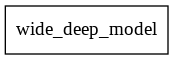

ValueError: ignored

In [ ]:
def display_best_model(tuner):
    '''ベストなモデルの構造を表示'''
    best_model = tuner.get_best_models()[0]
    display(plot_model(best_model))
    display(best_model.summary())


def display_best_hp(tuner):
    '''ベストなハイパーパラメータを表示'''
    best_hp = tuner.get_best_hyperparameters()[0]
    display(best_hp.get_config()['values'])


display_best_model(tuner)
display_best_hp(tuner)

# モデルの評価

In [ ]:
def take_best_model(tuner):
    '''ベストなモデルを取り出し'''
    best_model = tuner.get_best_models()[0]
    return best_model


model = take_best_model(tuner)   

## Kerasの組み込み評価関数

In [ ]:
score = model.evaluate(x=X_test_WideDeep, y=y_test, batch_size=256)
display('loss : {}, metric : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 3ms/step - loss: 70.2334 - root_mean_squared_error: 8.3809


'loss : 70.23336029052734, metric : 8.380855560302734'

## sklearnの評価関数

In [ ]:
%%time
def _calc_score(y_true, y_pred, sklearn_metric):
  '''sklearnの評価指標のスコアを計算'''
  score = sklearn_metric(y_true=y_true, y_pred=y_pred)
  return score


def evaluete_sk_metrics(y_true, y_pred, sklearn_metrics):
  '''sklearnの各種、評価関数を使用'''
  result = {}
  for sk_metric in sklearn_metrics:
    result[sk_metric.__name__] = _calc_score(y_true=y_true, y_pred=y_pred, sklearn_metric=sk_metric)
  return result


SK_METRICS=[r2_score, explained_variance_score, mean_squared_error]
eval_scores = {'train': {}, 'val': {}, 'test': {}}

for key, X, y_true in zip(['train', 'val', 'test'], [X_train_WideDeep, X_val_WideDeep, X_test_WideDeep], [y_train, y_val, y_test]):
  y_pred = model.predict_on_batch(x=X)[0]
  eval_scores[key] = evaluete_sk_metrics(y_true=y_true, y_pred=y_pred, sklearn_metrics=SK_METRICS)
pprint.pprint(eval_scores)

{'test': {'explained_variance_score': 0.003405272960662842,
          'mean_squared_error': 69.983734,
          'r2_score': 0.002507022347766119},
 'train': {'explained_variance_score': 0.0033373236656188965,
           'mean_squared_error': 92.772964,
           'r2_score': 0.003178983001525526},
 'val': {'explained_variance_score': 0.0040985941886901855,
         'mean_squared_error': 73.262184,
         'r2_score': 0.004098136087636872}}
CPU times: user 451 ms, sys: 12.5 ms, total: 463 ms
Wall time: 443 ms
